### Imports

In [2]:
import inspect
from typing import Any, Callable, Dict, List, Optional, Union

import numpy as np
import PIL
import torch
from packaging import version
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer

from diffusers.configuration_utils import FrozenDict
from diffusers.image_processor import PipelineImageInput, VaeImageProcessor
from diffusers.loaders import StableDiffusionLoraLoaderMixin, TextualInversionLoaderMixin
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.models.lora import adjust_lora_scale_text_encoder
from diffusers.schedulers import LCMScheduler
from diffusers.utils import PIL_INTERPOLATION, deprecate, logging
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker

In [3]:
from diffusers import LCMScheduler
from pipeline_ead_my import EditPipeline
import os
import gradio as gr
import torch
from PIL import Image
import torch.nn.functional as nnf
from typing import Optional, Union, Tuple, List, Callable, Dict
import abc
import ptp_utils
import utils
import numpy as np
import seq_aligner
import math
import argparse
import json
from datetime import datetime

In [4]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/home/mdnikolaev/darudenkov/InfEdit/utils.py'>

### Functions

In [5]:
# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.preprocess
def preprocess(image):
    deprecation_message = "The preprocess method is deprecated and will be removed in diffusers 1.0.0. Please use VaeImageProcessor.preprocess(...) instead"
    deprecate("preprocess", "1.0.0", deprecation_message, standard_warn=False)
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, PIL.Image.Image):
        image = [image]

    if isinstance(image[0], PIL.Image.Image):
        w, h = image[0].size
        w, h = (x - x % 8 for x in (w, h))  # resize to integer multiple of 8

        image = [np.array(i.resize((w, h), resample=PIL_INTERPOLATION["lanczos"]))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image

### DDCM sampler

In [6]:
def ddcm_sampler(scheduler, x_s, x_t, timestep, e_s, e_t, x_0, noise, eta, to_next=True):
    
    '''
    Семплинг идет от и до T -> T-1 -> T-2 -> ...-> 1 -> 0
    Args:
        scheduler: to set alphas on timesteps and control noise
        x_0: init image latent
        x_s: source latent
        x_t: target latent
        timestep
        e_s: predict of model for source DM(x_s, time, c_s)
        e_t: predict of model for source DM(x_t, time, c_t)
        noise
        eta: это коэфф при стандартном отклонклонии который задает стохастичность (см DDIM), std = eta * std(timestep) 
            при eta=0 нет стокхастичности и один путь семплинга, при eta=1 то же самое как у DDPM
            
    '''
    if scheduler.num_inference_steps is None:
        raise ValueError(
            "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
        )
    
    if scheduler.step_index is None:
        scheduler._init_step_index(timestep)

    prev_step_index = scheduler.step_index + 1
    if prev_step_index < len(scheduler.timesteps):
        prev_timestep = scheduler.timesteps[prev_step_index]
    else:
        prev_timestep = timestep

    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = (
        scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    )
    # but in DDPM
    # beta * (1. - alpha_bar_prev) / (1. - alpha_bar)
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    
    variance_base = beta_prod_t_prev  # from DDPM notation
    variance = (eta ** 2) * variance_base
    # std_dev_t = eta * variance ** 0.5
    
    # !!!
    # But in DDIM we have this formular for  variance = std_dev ** 2
    # variance = (eta ** 2) * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev))
    # std_dev_t = eta * variance ** 0.5
    
    noise = variance ** (0.5) * noise
    

    e_c = (x_s - alpha_prod_t ** (0.5) * x_0) / (1 - alpha_prod_t) ** (0.5)

    pred_x0 = x_0 + ((x_t - x_s) - beta_prod_t ** (0.5) * (e_t - e_s)) / alpha_prod_t ** (0.5)
    eps = (e_t - e_s) + e_c  # как в гайденсе (e_t - e_s) это чисто направление редактирования,типо чистая разница промтов, и добавляем консистенси шум что бынаправить на оригинал
    dir_xt = (beta_prod_t_prev - variance) ** (0.5) * eps  # при eta=1 -> dir_xt=0, но только если у нас параметризация  variance_base = beta_prod_t_prev

    #print(f"dir_xt={dir_xt}") # реально по 0
    # Noise is not used for one-step sampling.
    if len(scheduler.timesteps) > 1:
        prev_xt = alpha_prod_t_prev ** (0.5) * pred_x0 + dir_xt + noise
        prev_xs = alpha_prod_t_prev ** (0.5) * x_0 + dir_xt + noise
    else:
        prev_xt = pred_x0
        prev_xs = x_0
    
    if to_next:
      scheduler._step_index += 1
    return prev_xs, prev_xt, pred_x0

### BasePipeline

In [7]:
class BaseEditPipeline(DiffusionPipeline, TextualInversionLoaderMixin, StableDiffusionLoraLoaderMixin):
    model_cpu_offload_seq = "text_encoder->unet->vae"
    _optional_components = ["safety_checker", "feature_extractor"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: LCMScheduler,
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()
        
        # Вынесенная проверка компонентов
        self._validate_and_fix_components(scheduler, unet, safety_checker, feature_extractor, requires_safety_checker)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        self.register_to_config(requires_safety_checker=requires_safety_checker)
        
    def _validate_and_fix_components(self, scheduler, unet, safety_checker, feature_extractor, requires_safety_checker):
        if hasattr(scheduler.config, "steps_offset") and scheduler.config.steps_offset != 1:
            print("Catch deprecate scheduler when __init__")
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} is outdated. `steps_offset`"
                f" should be set to 1 instead of {scheduler.config.steps_offset}. Please make sure "
                "to update the config accordingly as leaving `steps_offset` might led to incorrect results"
                " in future versions. If you have downloaded this checkpoint from the Hugging Face Hub,"
                " it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json`"
                " file"
            )
            deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)

        if safety_checker is None and requires_safety_checker:
            print("Catch safety_checker and requires_safety_checker scheduler when __init__")
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            print("Catch safety_checker and feature_extractor scheduler when __init__")
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        is_unet_version_less_0_9_0 = hasattr(unet.config, "_diffusers_version") and version.parse(
            version.parse(unet.config._diffusers_version).base_version
        ) < version.parse("0.9.0.dev0")
        is_unet_sample_size_less_64 = hasattr(unet.config, "sample_size") and unet.config.sample_size < 64
        if is_unet_version_less_0_9_0 and is_unet_sample_size_less_64:
            print("Catch is_unet_version_less_0_9_0 when __init__")
            deprecation_message = (
                "The configuration file of the unet has set the default `sample_size` to smaller than"
                " 64 which seems highly unlikely .If you're checkpoint is a fine-tuned version of any of the"
                " following: \n- CompVis/stable-diffusion-v1-4 \n- CompVis/stable-diffusion-v1-3 \n-"
                " CompVis/stable-diffusion-v1-2 \n- CompVis/stable-diffusion-v1-1 \n- runwayml/stable-diffusion-v1-5"
                " \n- runwayml/stable-diffusion-inpainting \n you should change 'sample_size' to 64 in the"
                " configuration file. Please make sure to update the config accordingly as leaving `sample_size=32`"
                " in the config might lead to incorrect results in future versions. If you have downloaded this"
                " checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for"
                " the `unet/config.json` file"
            )
            deprecate("sample_size<64", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(unet.config)
            new_config["sample_size"] = 64
            unet._internal_dict = FrozenDict(new_config)
        

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._encode_prompt
    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        lora_scale: Optional[float] = None,
    ):
        deprecation_message = "`_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple."
        deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)

        prompt_embeds_tuple = self.encode_prompt(
            prompt=prompt,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
        )

        # concatenate for backwards comp
        prompt_embeds = torch.cat([prompt_embeds_tuple[1], prompt_embeds_tuple[0]])

        return prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.encode_prompt
    def encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        lora_scale: Optional[float] = None,
    ):
        # set lora scale so that monkey patched LoRA
        # function of text encoder can correctly access it
        if lora_scale is not None and isinstance(self, StableDiffusionLoraLoaderMixin):
            self._lora_scale = lora_scale

            # dynamically adjust the LoRA scale
            adjust_lora_scale_text_encoder(self.text_encoder, lora_scale)

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            # textual inversion: procecss multi-vector tokens if necessary
            if isinstance(self, TextualInversionLoaderMixin):
                prompt = self.maybe_convert_prompt(prompt, self.tokenizer)

            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            prompt_embeds = self.text_encoder(
                text_input_ids.to(device),
                attention_mask=attention_mask,
            )
            prompt_embeds = prompt_embeds[0]

        if self.text_encoder is not None:
            prompt_embeds_dtype = self.text_encoder.dtype
        elif self.unet is not None:
            prompt_embeds_dtype = self.unet.dtype
        else:
            prompt_embeds_dtype = prompt_embeds.dtype

        prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            # textual inversion: procecss multi-vector tokens if necessary
            if isinstance(self, TextualInversionLoaderMixin):
                uncond_tokens = self.maybe_convert_prompt(uncond_tokens, self.tokenizer)

            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            negative_prompt_embeds = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        return prompt_embeds, negative_prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline.check_inputs
    def check_inputs(
        self, prompt, strength, callback_steps, negative_prompt=None, prompt_embeds=None, negative_prompt_embeds=None
    ):
        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.run_safety_checker
    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is None:
            has_nsfw_concept = None
        else:
            if torch.is_tensor(image):
                feature_extractor_input = self.image_processor.postprocess(image, output_type="pil")
            else:
                feature_extractor_input = self.image_processor.numpy_to_pil(image)
            safety_checker_input = self.feature_extractor(feature_extractor_input, return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        return image, has_nsfw_concept

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.decode_latents
    def decode_latents(self, latents):
        deprecation_message = "The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead"
        deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)

        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.decode(latents, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline.get_timesteps
    def get_timesteps(self, num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start * self.scheduler.order :]

        return timesteps, num_inference_steps - t_start

    def prepare_latents(self, image, timestep, batch_size, num_images_per_prompt, dtype, device, denoise_model, generator=None):
        image = image.to(device=device, dtype=dtype)

        batch_size = image.shape[0]

        if image.shape[1] == 4:
            init_latents = image

        else:
            if isinstance(generator, list) and len(generator) != batch_size:
                raise ValueError(
                    f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                    f" size of {batch_size}. Make sure the batch size matches the length of the generators."
                )

            if isinstance(generator, list):
                init_latents = [
                    self.vae.encode(image[i : i + 1]).latent_dist.sample(generator[i]) for i in range(batch_size)
                ]
                init_latents = torch.cat(init_latents, dim=0)
            else:
                init_latents = self.vae.encode(image).latent_dist.sample(generator)

            init_latents = self.vae.config.scaling_factor * init_latents

        if batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] == 0:
            # expand init_latents for batch_size
            deprecation_message = (
                f"You have passed {batch_size} text prompts (`prompt`), but only {init_latents.shape[0]} initial"
                " images (`image`). Initial images are now duplicating to match the number of text prompts. Note"
                " that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update"
                " your script to pass as many initial images as text prompts to suppress this warning."
            )
            deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
            additional_image_per_prompt = batch_size // init_latents.shape[0]
            init_latents = torch.cat([init_latents] * additional_image_per_prompt * num_images_per_prompt, dim=0)
        elif batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `image` of batch size {init_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            init_latents = torch.cat([init_latents] * num_images_per_prompt, dim=0)

        # add noise to latents using the timestep
        shape = init_latents.shape
        noise = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

        # get latents
        clean_latents = init_latents
        if denoise_model:
            init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
            latents = init_latents
        else:
            latents = noise

        return latents, clean_latents

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        source_prompt: Union[str, List[str]],
        negative_prompt: Union[str, List[str]]=None,
        positive_prompt: Union[str, List[str]]=None,
        image: PipelineImageInput = None,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        original_inference_steps: Optional[int]  = 50,
        guidance_scale: Optional[float] = 7.5,
        source_guidance_scale: Optional[float] = 1,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 1.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        denoise_model: Optional[bool] = True,
    ):
        raise NotImplementedError("This method should be implemented in child classes")

In [8]:
class InfEditPipeline(BaseEditPipeline):
    
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        source_prompt: Union[str, List[str]],
        negative_prompt: Union[str, List[str]]=None,
        positive_prompt: Union[str, List[str]]=None,
        image: PipelineImageInput = None,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        original_inference_steps: Optional[int]  = 50,
        guidance_scale: Optional[float] = 7.5,
        source_guidance_scale: Optional[float] = 1,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 1.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        denoise_model: Optional[bool] = True,
    ):
        # 1. Check inputs
        self.check_inputs(prompt, strength, callback_steps)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        prompt_embeds_tuple = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            prompt_embeds=prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )
        source_prompt_embeds_tuple = self.encode_prompt(
            source_prompt, device, num_images_per_prompt, do_classifier_free_guidance, positive_prompt, None
        )
        if prompt_embeds_tuple[1] is not None:
            prompt_embeds = torch.cat([prompt_embeds_tuple[1], prompt_embeds_tuple[0]])
        else:
            prompt_embeds = prompt_embeds_tuple[0]
        if source_prompt_embeds_tuple[1] is not None:
            source_prompt_embeds = torch.cat([source_prompt_embeds_tuple[1], source_prompt_embeds_tuple[0]])
        else:
            source_prompt_embeds = source_prompt_embeds_tuple[0]

        # 4. Preprocess image
        image = self.image_processor.preprocess(image)

        # 5. Prepare timesteps
        self.scheduler.set_timesteps(
          num_inference_steps=num_inference_steps, 
          device=device, 
          original_inference_steps=original_inference_steps)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength, device)
        latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

        # 6. Prepare latent variables
        latents, clean_latents = self.prepare_latents(
            image, latent_timestep, batch_size, num_images_per_prompt, prompt_embeds.dtype, device, denoise_model, generator
        )
        source_latents = latents
        mutual_latents = latents

        # 8. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                source_latent_model_input = (
                    torch.cat([source_latents] * 2) if do_classifier_free_guidance else source_latents
                )
                mutual_latent_model_input = (
                    torch.cat([mutual_latents] * 2) if do_classifier_free_guidance else mutual_latents
                )
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                source_latent_model_input = self.scheduler.scale_model_input(source_latent_model_input, t)
                mutual_latent_model_input = self.scheduler.scale_model_input(mutual_latent_model_input, t)

                # predict the noise residual
                if do_classifier_free_guidance:
                    concat_latent_model_input = torch.stack(
                        [
                            source_latent_model_input[0],
                            latent_model_input[0],
                            mutual_latent_model_input[0],
                            source_latent_model_input[1],
                            latent_model_input[1],
                            mutual_latent_model_input[1],
                        ],
                        dim=0,
                    )
                    concat_prompt_embeds = torch.stack(
                        [
                            source_prompt_embeds[0],
                            prompt_embeds[0],
                            source_prompt_embeds[0],
                            source_prompt_embeds[1],
                            prompt_embeds[1],
                            source_prompt_embeds[1],
                        ],
                        dim=0,
                    )
                else:
                    concat_latent_model_input = torch.cat(
                        [
                            source_latent_model_input,
                            latent_model_input,
                            mutual_latent_model_input,
                        ],
                        dim=0,
                    )
                    concat_prompt_embeds = torch.cat(
                        [
                            source_prompt_embeds,
                            prompt_embeds,
                            source_prompt_embeds,
                        ],
                        dim=0,
                    )

                concat_noise_pred = self.unet(
                    concat_latent_model_input,
                    t,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_hidden_states=concat_prompt_embeds,
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    (
                        source_noise_pred_uncond,
                        noise_pred_uncond,
                        mutual_noise_pred_uncond,
                        source_noise_pred_text,
                        noise_pred_text,
                        mutual_noise_pred_text
                    ) = concat_noise_pred.chunk(6, dim=0)

                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                    source_noise_pred = source_noise_pred_uncond + source_guidance_scale * (
                        source_noise_pred_text - source_noise_pred_uncond
                    )
                    mutual_noise_pred = mutual_noise_pred_uncond + source_guidance_scale * (
                        mutual_noise_pred_text - mutual_noise_pred_uncond
                    )

                else:
                    (source_noise_pred, noise_pred, mutual_noise_pred) = concat_noise_pred.chunk(3, dim=0)

                noise = torch.randn(
                    latents.shape, dtype=latents.dtype, device=latents.device, generator=generator
                )

                _, latents, pred_x0 = ddcm_sampler(
                  self.scheduler, source_latents, 
                  latents, t, 
                  source_noise_pred, noise_pred, 
                  clean_latents, noise=noise, 
                  eta=eta, to_next=False, 
                )
                
                source_latents, mutual_latents, pred_xm = ddcm_sampler(
                  self.scheduler, source_latents, 
                  mutual_latents, t, 
                  source_noise_pred, mutual_noise_pred, 
                  clean_latents, noise=noise, 
                  eta=eta,
                )

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        alpha_prod_t = self.scheduler.alphas_cumprod[t]
                        mutual_latents, latents = callback(i, t, source_latents, latents, mutual_latents, alpha_prod_t)

        # 9. Post-processing
        if not output_type == "latent":
            image = self.vae.decode(pred_x0 / self.vae.config.scaling_factor, return_dict=False)[0]
            #image_m = self.vae.decode(pred_xm / self.vae.config.scaling_factor, return_dict=False)[0]
        else:
            image = pred_x0

        # Удаляем проверку на NSFW
        do_denormalize = [True] * image.shape[0]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)
        #image_m = self.image_processor.postprocess(image_m, output_type=output_type, do_denormalize=do_denormalize)

        if not return_dict:
            return (image, None)
        # return (
        #     StableDiffusionPipelineOutput(images=image, nsfw_content_detected=None),
        #     StableDiffusionPipelineOutput(images=image_m, nsfw_content_detected=None),
        # )

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=None)

### DualBranch pipeline

In [9]:
class DualBranchEditPipeline(BaseEditPipeline):
    
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],  # target_prompt
        source_prompt: Union[str, List[str]],
        image: PipelineImageInput = None,
        num_inference_steps: Optional[int] = 50,
        original_inference_steps: Optional[int]  = 50,
        guidance_scale: Optional[float] = 7.5,
        source_guidance_scale: Optional[float] = 1,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 1.0,  # стохастичность семплинга типа из ДДИМ
        output_type: Optional[str] = "pil",  # np
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,  # функция работы с эттеншенами
        is_save_intermediate_pred_results = True,
        # ХУЕТА
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        strength: float = 1,  # до какого шага зашумляем изображение и откуда идет старт расшумления, влияет на таймстепы шедулера
        denoise_model: Optional[bool] = True,  # какая-то хуета. Если тру, то при подготовке латентов, мы шедулером шумим изначальне латенты изображение, если фолз, то просто приравнивает нойзу. см prepare_latents
        callback_steps: int = 1,  # через сколько шагов делается колбэк этеншенов, если 1 на всех если 2 на каждом втором
        negative_prompt: Union[str, List[str]]=None,
        positive_prompt: Union[str, List[str]]=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
    ):
        # 1. Check inputs
        self.check_inputs(prompt, strength, callback_steps)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        prompt_embeds_tuple = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            prompt_embeds=prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )
        source_prompt_embeds_tuple = self.encode_prompt(
            source_prompt, device, num_images_per_prompt, do_classifier_free_guidance, positive_prompt, None
        )
        if prompt_embeds_tuple[1] is not None:
            prompt_embeds = torch.cat([prompt_embeds_tuple[1], prompt_embeds_tuple[0]])
        else:
            prompt_embeds = prompt_embeds_tuple[0]
        if source_prompt_embeds_tuple[1] is not None:
            source_prompt_embeds = torch.cat([source_prompt_embeds_tuple[1], source_prompt_embeds_tuple[0]])
        else:
            source_prompt_embeds = source_prompt_embeds_tuple[0]

        # 4. Preprocess image
        image = self.image_processor.preprocess(image)

        # 5. Prepare timesteps
        self.scheduler.set_timesteps(
          num_inference_steps=num_inference_steps, 
          device=device, 
          original_inference_steps=original_inference_steps)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength, device)
        latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

        # 6. Prepare latent variables
        latents, clean_latents = self.prepare_latents(
            image, latent_timestep, batch_size, num_images_per_prompt, prompt_embeds.dtype, device, denoise_model
        )
        source_latents = latents

        # 8. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order  # ордер вроде 1, num_inference_steps по сути должен совпдаать с длиной таймстепов. Т.е по 0
        assert  num_warmup_steps == 0, "А вот нихуя num_warmup_steps не 0"
        
        
        list_pred_x0 = [clean_latents]
        
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                source_latent_model_input = (
                    torch.cat([source_latents] * 2) if do_classifier_free_guidance else source_latents
                )

                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                source_latent_model_input = self.scheduler.scale_model_input(source_latent_model_input, t)

                # predict the noise residual
                if do_classifier_free_guidance:
                    concat_latent_model_input = torch.stack(
                        [
                            source_latent_model_input[0],
                            latent_model_input[0],
                            source_latent_model_input[1],
                            latent_model_input[1],
                        ],
                        dim=0,
                    )
                    concat_prompt_embeds = torch.stack(
                        [
                            source_prompt_embeds[0],
                            prompt_embeds[0],
                            source_prompt_embeds[1],
                            prompt_embeds[1],
                        ],
                        dim=0,
                    )
                else:
                    concat_latent_model_input = torch.cat(
                        [
                            source_latent_model_input,
                            latent_model_input,
                        ],
                        dim=0,
                    )
                    concat_prompt_embeds = torch.cat(
                        [
                            source_prompt_embeds,
                            prompt_embeds,
                        ],
                        dim=0,
                    )

                concat_noise_pred = self.unet(
                    concat_latent_model_input,
                    t,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_hidden_states=concat_prompt_embeds,
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    (
                        source_noise_pred_uncond,
                        noise_pred_uncond,
                        source_noise_pred_text,
                        noise_pred_text,
                    ) = concat_noise_pred.chunk(4, dim=0)

                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                    source_noise_pred = source_noise_pred_uncond + source_guidance_scale * (
                        source_noise_pred_text - source_noise_pred_uncond
                    )

                else:
                    (source_noise_pred, noise_pred) = concat_noise_pred.chunk(2, dim=0)

                noise = torch.randn(
                    latents.shape, dtype=latents.dtype, device=latents.device
                )

                source_latents, latents, pred_x0 = ddcm_sampler(
                    self.scheduler, 
                    x_s=source_latents, 
                    x_t=latents, 
                    timestep=t, 
                    e_s=source_noise_pred,
                    e_t=noise_pred, 
                    x_0=clean_latents, 
                    noise=noise, 
                    eta=eta,
                )

                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    # call the callback, if provided
                    if callback is not None and i % callback_steps == 0:
                        alpha_prod_t = self.scheduler.alphas_cumprod[t]
                        latents = callback(i, t, source_latents, latents, alpha_prod_t)
                list_pred_x0.append(pred_x0)
                # list_pred_x0 здесь от изначального изображения до коннечного, карасиво посмотреть
                # но что бы не утруждаться вычислениями, оставим последний
                list_pred_x0 = list_pred_x0[-1:]

        # 9. Post-processing
        result = {"pred_x0": []}
        
        if is_save_intermediate_pred_results:
            for tmp_pred_x0 in list_pred_x0:
                if not output_type == "latent":
                    tmp_image = self.vae.decode(tmp_pred_x0 / self.vae.config.scaling_factor, return_dict=False)[0]
                else:
                    tmp_image = tmp_pred_x0
                    
                do_denormalize = [True] * tmp_image.shape[0]
                tmp_image = self.image_processor.postprocess(tmp_image, output_type=output_type, do_denormalize=do_denormalize)
                result["pred_x0"].append(tmp_image)
        else:  
            if not output_type == "latent":
                image = self.vae.decode(pred_x0 / self.vae.config.scaling_factor, return_dict=False)[0]
            else:
                image = pred_x0

            do_denormalize = [True] * image.shape[0]
            print(f"do_denormalize={do_denormalize}")
            image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)
            result["pred_x0"].append(image)

        return result
        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=None)

### Выбор картинок

```
change
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/1_change_object_80/2_natural/1_animal/121000000001.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/1_change_object_80/1_artificial/1_animal/111000000007.jpg

add
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/2_add_object_80/1_artificial/3_indoor/213000000005.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/2_add_object_80/2_natural/1_animal/221000000002.jpg

remove
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/3_delete_object_80/1_artificial/3_indoor/313000000009.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/3_delete_object_80/1_artificial/1_animal/311000000003.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/3_delete_object_80/2_natural/1_animal/321000000004.jpg

change obj
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/4_change_attribute_content_40/1_artificial/1_animal/411000000004.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/4_change_attribute_content_40/2_natural/3_indoor/423000000002.jpg

change pose
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/5_change_attribute_pose_40/1_artificial/1_animal/511000000002.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/5_change_attribute_pose_40/2_natural/1_animal/521000000000.jpg

change color
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/6_change_attribute_color_40/2_natural/1_animal/621000000000.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/6_change_attribute_color_40/1_artificial/2_human/612000000003.jpg

change material
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/7_change_attribute_material_40/1_artificial/2_human/712000000001.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/7_change_attribute_material_40/2_natural/1_animal/721000000000.jpg

change background
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/8_change_background_80/1_artificial/1_animal/811000000009.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/8_change_background_80/1_artificial/2_human/812000000000.jpg

change style
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/9_change_style_80/1_artificial/1_animal/911000000001.jpg
/home/mdnikolaev/darudenkov/InfEdit/data/annotation_images/9_change_style_80/2_natural/2_human/922000000000.jpg
```

In [10]:
CHOOSE_IMAGES_IDS = [
    # change object
    "121000000001",
    "111000000007",

    # add object
    "213000000005",
    "221000000002",

    # remove object
    "313000000009",
    "311000000003",
    "321000000004",

    # change object content
    "411000000004",
    "423000000002",

    # change pose
    "511000000002",
    "521000000000",

    # change color
    "621000000000",
    "612000000003",

    # change material
    "712000000001",
    "721000000000",

    # change background
    "811000000009",
    "812000000000",

    # change style
    "911000000001",
    "922000000000"
]

In [11]:
annotation_file_name = os.path.join("data", "mapping_file.json")
with open(annotation_file_name) as f:
    annotation_file = json.load(f)

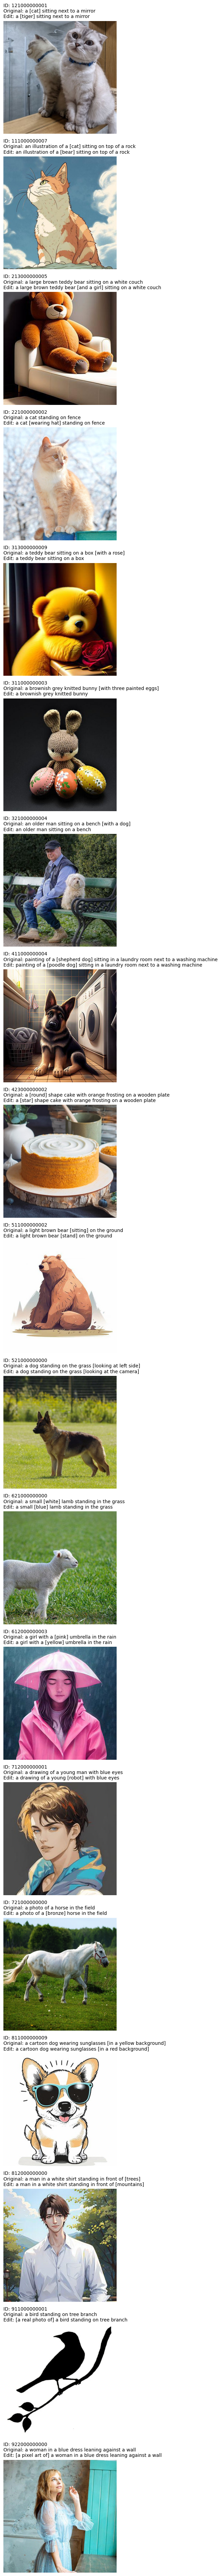

In [12]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt

# Путь к корню изображений
IMAGE_ROOT = "data/annotation_images"

# Создание визуализации
fig, axes = plt.subplots(len(CHOOSE_IMAGES_IDS), 1, figsize=(8, len(CHOOSE_IMAGES_IDS) * 4))

if len(CHOOSE_IMAGES_IDS) == 1:
    axes = [axes]  # Чтобы работало с одним изображением

for ax, img_id in zip(axes, CHOOSE_IMAGES_IDS):
    try:
        # Данные по ID
        info = annotation_file[img_id]
        img_path = os.path.join(IMAGE_ROOT, info["image_path"])
        img = Image.open(img_path)

        # Отображение
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"ID: {img_id}\nOriginal: {info['original_prompt']}\nEdit: {info['editing_prompt']}",
                     fontsize=10, loc='left')
    except Exception as e:
        ax.text(0.5, 0.5, f"Error loading {img_id}: {e}", ha='center', va='center')
        ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
CHOOSE_IMAGES_IDS = [
    "121000000001", # кот
    "311000000003", # заяц с яйцами 
    "423000000002", # торт
    "511000000002", # медведь
]

### Запуск DualBranch

In [14]:
LOW_RESOURCE = False
MAX_NUM_WORDS = 77


#torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
torch_dtype = torch.float32

model_id_or_path = "SimianLuo/LCM_Dreamshaper_v7"

device_print = "GPU 🔥" if torch.cuda.is_available() else "CPU 🥶"
print(device_print)
device = "cuda" if torch.cuda.is_available() else "cpu"

scheduler = LCMScheduler.from_pretrained(model_id_or_path, subfolder="scheduler")
pipe_DualBranch = DualBranchEditPipeline.from_pretrained(model_id_or_path, scheduler=scheduler, torch_dtype=torch_dtype).to(device)
tokenizer_DualBranch = pipe_DualBranch.tokenizer
encode_DualBranch = pipe_DualBranch.text_encoder

GPU 🔥


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
def inference(
    pipe,
    img,
    source_prompt, 
    target_prompt,
    local, 
    mutual, 
    guidance_s, 
    guidance_t, 
    num_inference_steps,
    cross_replace_steps, 
    self_replace_steps, 
    eta, 
    thresh_e, 
    thresh_m,
    strength,
    denoise,
    seed=0,
    width=512, 
    height=512, 
    positive_prompt=None,
    negative_prompt=None,
    verbose=True,
):
    if verbose: print(f"Pipe model: {pipe.__class__.__name__}")

    torch.manual_seed(seed)
    ratio = min(height / img.height, width / img.width)
    img = img.resize((int(img.width * ratio), int(img.height * ratio)))
    
    # ХУЕТА. Здесь руками рассчитывается точка старта работы этеншена. Тип с 0 шага или с 3
    if denoise is False:
        strength = 1
    num_denoise_num = math.trunc(num_inference_steps*strength)
    num_start = num_inference_steps-num_denoise_num
    
    # # create the CAC controller.
    # local_blend = LocalBlend(thresh_e=thresh_e, thresh_m=thresh_m, save_inter=False)
    # controller = AttentionRefine([source_prompt, target_prompt],[[local, mutual]],
    #                 num_inference_steps,
    #                 num_start,
    #                 cross_replace_steps=cross_replace_steps,
    #                 self_replace_steps=self_replace_steps,
    #                 local_blend=local_blend
    #                 )
    # ptp_utils.register_attention_control(pipe, controller)
    controller = None

    # Запуск
    pipe_params = {
        "prompt": target_prompt,
        "source_prompt": source_prompt,
        "positive_prompt": positive_prompt,
        "negative_prompt": negative_prompt,
        "image": img,
        "num_inference_steps": num_inference_steps,
        "eta": eta,
        "strength": strength,
        "guidance_scale": guidance_t,
        "source_guidance_scale": guidance_s,
        "denoise_model": denoise,
        "callback": controller.step_callback if controller else None,
    }
    
    # if verbose: 
    #     print("Запуск пайплайна с параметрами:")
    #     for key, value in pipe_params.items():
    #         print(f"  {key}: {value}")
        
    result = pipe(**pipe_params)

    return result

In [16]:
def run_inference(pipe, annotation_idx, annotation, base_params, manual_params, dataset_path):    
    """
    annotation_idx: индекс из джсон датасета пайбенч
    manual_params: параметры запуска
    annotation: это данные по индексу картинки из джсон пайбенча
    dataset_path: путь по изобрадения
    base_params: базовые параметры из конфига запуска
    save_doubles_images_w_unique_name: сохранять ли дубли. нужно если в одном конфиге запуска есть изображения 
        у которых разные мануальные параметры, тогда сохраняется с добавлением (i), как обычно
    """
    print(annotation_idx)
    image_path = os.path.join(dataset_path, "annotation_images", annotation["image_path"])
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    imagein = Image.open(image_path).convert("RGB")
    
    # обновляем параметры если они прописаны отдельно в изображении
    params = base_params.copy()
    params.update(manual_params)
    annotation.update(manual_params)

    inference_params = {
        "pipe": pipe,
        "img": imagein,
        "source_prompt": annotation["original_prompt"],
        "target_prompt": annotation["editing_prompt"] if annotation["editing_prompt"] != "source_prompt" else annotation["original_prompt"],
        "positive_prompt": params.get("positive_prompt", ""),
        "negative_prompt": params.get("negative_prompt", ""),
        "local": annotation["blended_word"].split(" ")[1] if annotation["blended_word"] != "" else "",
        "mutual": params.get("mutual", ""),
        "guidance_s": params["guidance_s"],
        "guidance_t": params["guidance_t"],
        "num_inference_steps": params["num_inference_steps"],
        "width": params.get("width", 512),
        "height": params.get("height", 512),
        "seed": params["seed"],
        "strength": params["strength"],
        "cross_replace_steps": params["cross_replace_steps"],
        "self_replace_steps": params["self_replace_steps"],
        "eta": params["eta"],
        "thresh_e": params["thresh_e"],
        "thresh_m": params["thresh_m"],
        "denoise": params["denoise"]
    }

    # print("Запуск инференса с параметрами:")
    # for key, value in inference_params.items():
    #     print(f"  {key}: {value}")
    
    result = inference(**inference_params)   
    return result

In [62]:
def run_experiment(pipe, config, is_save_images=True):
    result = []
    # получение путей
    dataset_path = config["source_path"]
    target_path = os.path.join(config["target_path"], config["exp_name"])
    base_params = config["base_params"]
    print(f"target_path={target_path}")
    print(f'config["target_path"]={config["target_path"]}')
    print(f'config["exp_name"]={config["exp_name"]}')
    print(config)
    
    # загрузка инфы о датасете
    annotation_file_name = os.path.join(dataset_path, "mapping_file.json")
    with open(annotation_file_name) as f:
        annotation_file = json.load(f)
        
    # Создаем target_path куда все сохранять будем
    if os.path.exists(target_path):
        print(f"⚠️ Папка {target_path} уже существует.")
        user_input = input("Хотите продолжить? Это может повлечь удаление данных. (y/n): ").strip().lower()
        if user_input == 'y':
            os.makedirs(target_path, exist_ok=True)
        else:
            print("Остановка эксперимента")
            return
    else: 
        os.makedirs(target_path, exist_ok=True)

    # Сохраняем конфиг
    # Предполагаем, что target_path и config уже определены
    base_filename = "config"
    extension = ".json"
    config_file_path = os.path.join(target_path, base_filename + extension)
    # Найти свободное имя файла
    counter = 1
    while os.path.exists(config_file_path):
        config_file_path = os.path.join(target_path, f"{base_filename}_{counter}{extension}")
        counter += 1
    # Сохраняем
    with open(config_file_path, 'w') as f:
        json.dump(config, f, indent=4)
    
    # запуск иныеренса на всех картинках
    for image_id, manual_params  in config["images"]:
        if image_id in annotation_file:
            image_annotation = annotation_file[image_id]
            inference_result = run_inference(pipe, image_id, image_annotation, base_params, manual_params, dataset_path)
            # выход это дикт с какими-то ключами в которых картинки
            result.append(inference_result)
            
            list_pred_x0 = inference_result["pred_x0"]
            edited_image = list_pred_x0[-1][0]

            if is_save_images:
                # сохраняем эдитинг
                # Формируем путь до папки, как в PIE-Bench
                edited_img_pie_bench_save_path = os.path.join(target_path, "annotation_images", os.path.dirname(image_annotation["image_path"]))
                image_name, image_ext = os.path.splitext(os.path.basename(image_annotation["image_path"]))
                # Сохраняем изображение
                utils.save_inference_image(
                    edited_image,
                    image_name,
                    image_ext,
                    target_path,
                    save_doubles_images_w_postfix=True
                )

                # Сохранение последователности одной ветки pred_x0
                # utils.save_inference_image(
                #     utils.concat_images_horizontally(list_pred_x0), 
                #     image_name + "_pred_x0",
                #     image_ext,
                #     target_path, 
                #     save_doubles_images_w_postfix=True)
                
        else:
            print(f"Annotation not found for image ID: {image_id}")
    return result, target_path

##### Один тестовый запуск

In [18]:
config = {
    "exp_name": "testStart", #+ f"_{datetime.now().strftime('%Y%m%d_%H%M')}",
    "source_path": "data",
    "target_path": "experiments/imgs_results/clearDualBranch",
    "base_params": {
        "guidance_s": 1.0,
        "guidance_t": 1.0,
        "num_inference_steps": 10,
        "seed": 0,
        "cross_replace_steps": 0.0, # не рабоатет
        "self_replace_steps": 1, # не работает
        "eta": 1,
        "thresh_e": 0.2, # не работает
        "thresh_m": 0.0, # не работает
        "strength": 1.0,
        "denoise": True,
        "positive_prompt": "", # не работает
        "negative_prompt": "", # не работает
        "mutual": ""  # не работает
    },
     "images": [
        ["121000000001", {"guidance_t": 5.0, "guidance_s": 1.0,}],
        ["111000000007", {"guidance_t": 5.0, "guidance_s": 1.0,}],
     ]
}

In [53]:
result = run_experiment(pipe_DualBranch, config, is_save_images=True)

⚠️ Папка experiments/imgs_results/clearDualBranch/testStart уже существует.


Хотите продолжить? Это может повлечь удаление данных. (y/n):  n


Остановка эксперимента


### Эксперименты dualBranch

#### Голый DDCM cемплинг инфэдита

##### Как при обычном варианте работают гайденсы
Т.е грид где сверху гайденс сорс внизу гайденс таргета

In [63]:
config = {
    "exp_name": "", #f"_{datetime.now().strftime('%Y%m%d_%H%M')}",
    "source_path": "data",
    "target_path": "experiments/imgs_results/clearDualBranch/guidence",
    "base_params": {
        "guidance_s": 1.0,
        "guidance_t": 1.0,
        "num_inference_steps": 10,
        "seed": 0,
        "cross_replace_steps": 0.0, # не рабоатет
        "self_replace_steps": 1, # не работает
        "eta": 1,
        "thresh_e": 0.2, # не работает
        "thresh_m": 0.0, # не работает
        "strength": 1.0,
        "denoise": True,
        "positive_prompt": "", # не работает
        "negative_prompt": "", # не работает
        "mutual": ""  # не работает
    },
     "images": [],
}

In [64]:
CHOOSE_IMAGES_IDS

['121000000001', '311000000003', '423000000002', '511000000002']

In [66]:
# guidence_grid = [0, 0.25, 0.5, 0.75, 1, 1.5, 2.5, 5, 10, 15, 20]
guidence_grid = [0, 0.5, 1, 1.5, 2, 2.5, 5]
for g_s in guidence_grid:
    manual_params = []
    # список параметров для одного изображения в експерименте
    for g_t in guidence_grid:
        manual_params.append({"guidance_s": g_s, "guidance_t": g_t})
    #print(manual_params)
    # джойним параметры к каждому изображению и формируем images
    imgages_for_config = []
    for img_id in CHOOSE_IMAGES_IDS:
        imgages_for_config.extend([[img_id, k] for k in manual_params])
    #print("##__imgages_for_config", imgages_for_config)
    # обновляем параметр конфига
    g_s_config = config.copy()
    g_s_config.update({"images": imgages_for_config})
    g_s_config["exp_name"] = f"g_s_{g_s}"
    print(f'g_s_config["exp_name"]={g_s_config["exp_name"]}')
    print(f'g_s_config["target_path"]={g_s_config["exp_name"]}')
    print(f'g_s_config["images"]={g_s_config["images"][1]}')
    # запускаем эксперимент
    _ = run_experiment(pipe_DualBranch, g_s_config, is_save_images=True)
    break

g_s_config["exp_name"]=g_s_0
g_s_config["target_path"]=g_s_0
g_s_config["images"]=['121000000001', {'guidance_s': 0, 'guidance_t': 0.5}]
target_path=experiments/imgs_results/clearDualBranch/guidence/g_s_0
config["target_path"]=experiments/imgs_results/clearDualBranch/guidence
config["exp_name"]=g_s_0
{'exp_name': 'g_s_0', 'source_path': 'data', 'target_path': 'experiments/imgs_results/clearDualBranch/guidence', 'base_params': {'guidance_s': 1.0, 'guidance_t': 1.0, 'num_inference_steps': 10, 'seed': 0, 'cross_replace_steps': 0.0, 'self_replace_steps': 1, 'eta': 1, 'thresh_e': 0.2, 'thresh_m': 0.0, 'strength': 1.0, 'denoise': True, 'positive_prompt': '', 'negative_prompt': '', 'mutual': ''}, 'images': [['121000000001', {'guidance_s': 0, 'guidance_t': 0}], ['121000000001', {'guidance_s': 0, 'guidance_t': 0.5}], ['121000000001', {'guidance_s': 0, 'guidance_t': 1}], ['121000000001', {'guidance_s': 0, 'guidance_t': 1.5}], ['121000000001', {'guidance_s': 0, 'guidance_t': 2}], ['121000000001',

  0%|          | 0/10 [00:00<?, ?it/s]

121000000001
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

121000000001
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

121000000001
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

121000000001
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

121000000001
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

121000000001
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

311000000003
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

311000000003
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

311000000003
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

311000000003
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

311000000003
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

311000000003
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

311000000003
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

423000000002
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

423000000002
Pipe model: DualBranchEditPipeline


  0%|          | 0/10 [00:00<?, ?it/s]

423000000002
Pipe model: DualBranchEditPipeline


KeyboardInterrupt: 

In [ ]:
tmp_configs

##### Проверяем как высчитывается дисперся в семплере

In [54]:
num_inference_steps = 10
original_inference_steps = 50
eta = 1

In [55]:

scheduler.set_timesteps(
          num_inference_steps=num_inference_steps, 
          device=device, 
          original_inference_steps=original_inference_steps)

timesteps = scheduler.timesteps
timestep = timesteps[2]

In [56]:
timesteps

tensor([999, 899, 799, 699, 599, 499, 399, 299, 199,  99])

In [16]:
if scheduler.num_inference_steps is None:
    raise ValueError(
        "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
    )

if scheduler.step_index is None:
    scheduler._init_step_index(timestep)

prev_step_index = scheduler.step_index + 1
if prev_step_index < len(scheduler.timesteps):
    prev_timestep = scheduler.timesteps[prev_step_index]
else:
    prev_timestep = timestep

alpha_prod_t = scheduler.alphas_cumprod[timestep]
alpha_prod_t_prev = (
    scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
)
beta_prod_t = 1 - alpha_prod_t
beta_prod_t_prev = 1 - alpha_prod_t_prev

variance_base = beta_prod_t_prev  # from DDPM notation
variance = eta * variance_base

# Но может высчитать через формулу которая в DDIM
variance_ddim_formular = (eta ** 2) * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev))

In [17]:
print(f"variance_ddpm_formular={variance}\nvariance_ddim_formular={variance_ddim_formular}")

variance_ddpm_formular=0.9628050327301025
variance_ddim_formular=0.5180101990699768


##### Продолжаем